# Analysis

Setup:

In [1]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

In [2]:
import duckdb
import pandas as pd
from plotnine import *
from mizani.formatters import percent_format

%load_ext sql
conn = conn = duckdb.connect(f"md:my_db?motherduck_token={woops_add_your_token_here}")
%sql conn --alias duckdb

# Hiring Health

In [3]:
%%sql applications_data <<

SELECT
    f.application_id,
    j.job_id,
    j.job_title,
    c.candidate_id,
    f.application_date,
    f.is_hired,
    f.was_offered,
    f.is_rejected,
    f.is_approved,
    f.still_active,
    f.approval_date,
    f.hours_to_approval,
    f.hours_to_decision,
    c.source
FROM my_db.main_greenhouse_mart.fct_applications AS f
LEFT JOIN my_db.main_greenhouse_mart.dim_candidate AS c
    ON f.candidate_id = c.candidate_id
LEFT JOIN my_db.main_greenhouse_mart.dim_job AS j
    ON f.job_id = j.job_id
    AND f.application_id = j.application_id
WHERE 
    1 = 1 

In [140]:
%%sql apps_by_title_and_week <<

SELECT 
    job_title,
    WEEK(application_date) AS app_week,
    COUNT(*) AS app_cnt
FROM applications_data
GROUP BY job_title, app_week

In [141]:
apps_by_title_and_week

,job_title,app_week,app_cnt
0,Frontend Engineer,18,22
1,Product Data Scientist,18,24
2,Platform Engineer,16,19
3,Product Data Scientist,17,18
4,Frontend Engineer,17,19
5,Frontend Engineer,16,21
6,Product Data Scientist,16,15
7,Backend Engineer,20,7
8,Data Engineer,20,10
9,Software Engineer,16,18


/home/user/flask-dlt-dbt/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/user/flask-dlt-dbt/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/user/flask-dlt-dbt/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/user/flask-dlt-dbt/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/user/flask-dlt-dbt/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/user/flask-dlt-dbt/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: 

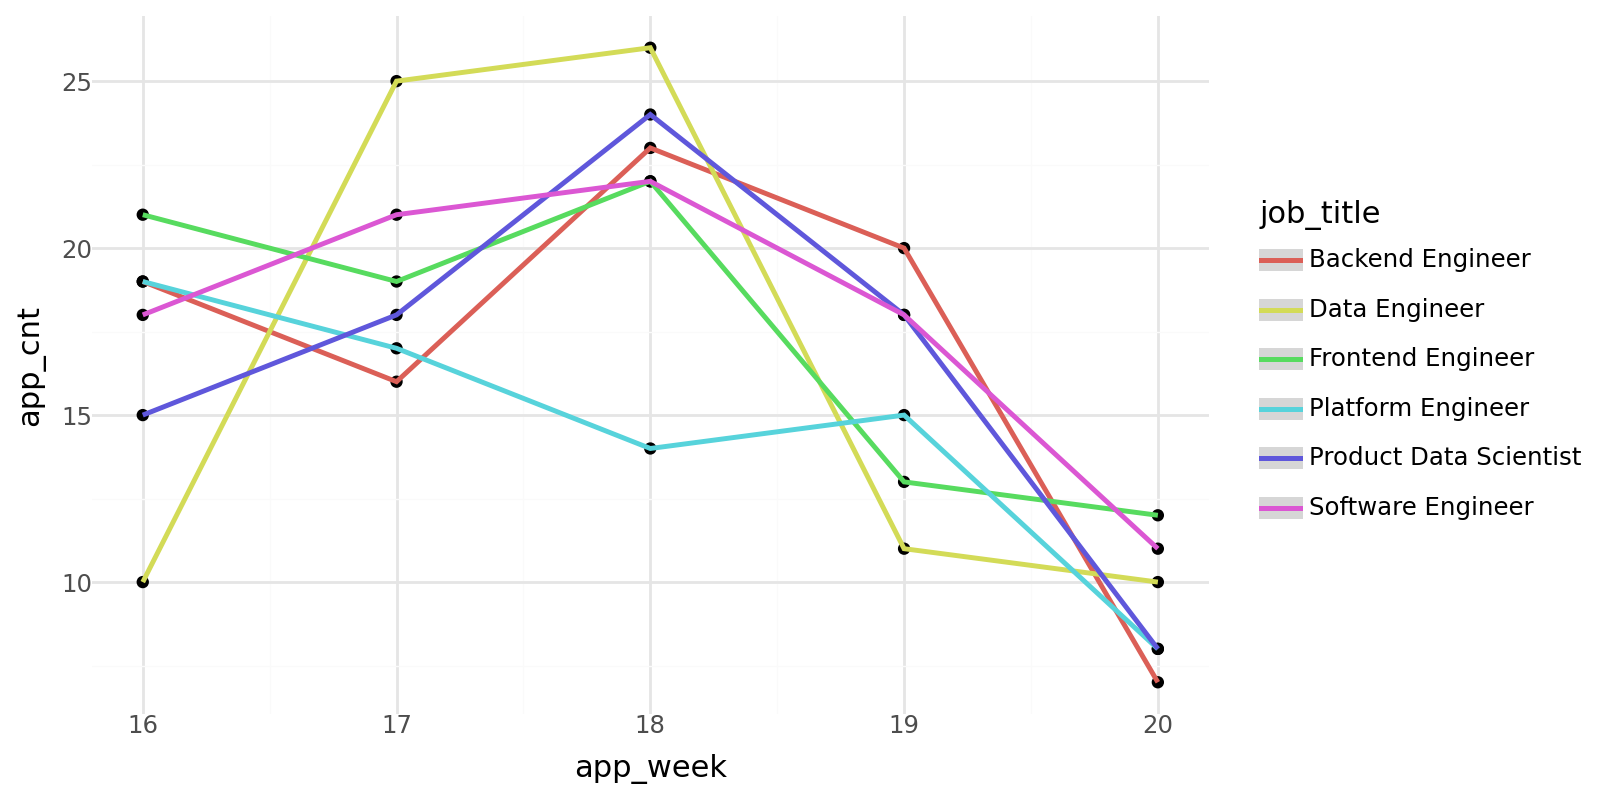

In [142]:
(
    ggplot(
        (
            apps_by_title_and_week
        ), 
        aes('app_week', 'app_cnt')
    )
    + geom_point()
    + geom_smooth(
        aes(color='job_title'), 
        # show_legend=False
    )
    + theme_minimal()
    + theme(
        legend_position='right',
        figure_size=(8, 4) # w, h
    )
)

In [7]:
%%sql hire_stats <<

SELECT 
    job_title,
    COUNT(*) AS application_cnt,
    CAST(COUNTIF(is_hired) AS INT) AS hire_cnt,
    CAST(COUNTIF(still_active) AS INT) AS active_cnt,
    (active_cnt / application_cnt) * 100 AS pct_active,
    (hire_cnt / application_cnt) * 100 AS hire_rate
FROM applications_data
WHERE
    1 = 1
GROUP BY job_title
ORDER BY hire_rate DESC

In [17]:
(
    hire_stats
    .sort_values('application_cnt', ascending=False)
    .assign(job_title=lambda x: pd.Categorical(x['job_title'], x['job_title'].unique(), ordered=True))
)

,job_title,application_cnt,hire_cnt,active_cnt,pct_active,hire_rate
2,Software Engineer,90,3,28,31.111111,3.333333
0,Frontend Engineer,87,8,22,25.287356,9.195402
1,Backend Engineer,85,3,20,23.529412,3.529412
5,Product Data Scientist,83,0,13,15.662651,0.000000
3,Data Engineer,82,2,14,17.073171,2.439024
4,Platform Engineer,73,1,16,21.917808,1.369863


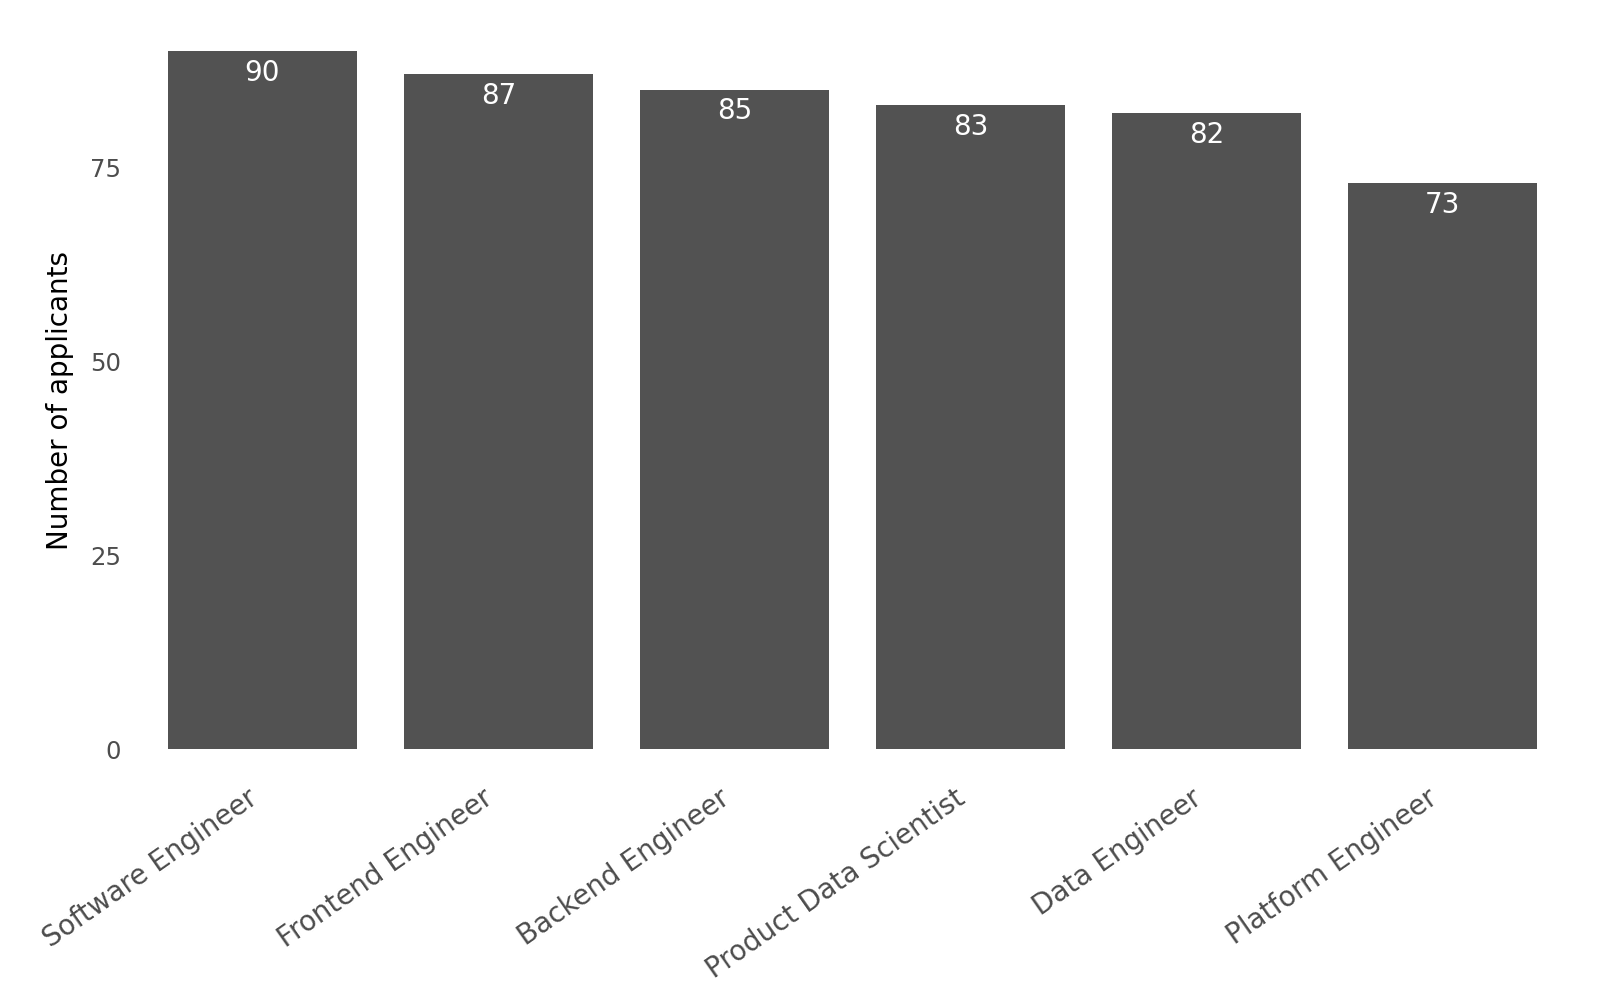

In [210]:
(
    ggplot(
        (
            hire_stats
            .sort_values('application_cnt', ascending=False)
            .assign(job_title=lambda x: pd.Categorical(x['job_title'], x['job_title'].unique(), ordered=True))
        ), 
        aes('job_title', 'application_cnt')
    )
    + geom_col(fill='#525252', width=0.8)
    + geom_text(
        aes(label='application_cnt'),  # Map the 'application_cnt' column to labels
        color='white',  # Set the text color to white
        va='top',  # Vertical alignment: 'top', 'middle', 'bottom'
        nudge_y=-1, # Nudge the text slightly down to be inside the bar
        size=10
    )    
    + theme_minimal()
    + labs(
        title="",
        x="",
        y="Number of applicants"
    )
    + theme(
        axis_text_x=element_text(angle=35, hjust=1, size=10),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        figure_size=(8, 5), # w, h
        axis_title_y=element_text(size=10),
    )
)

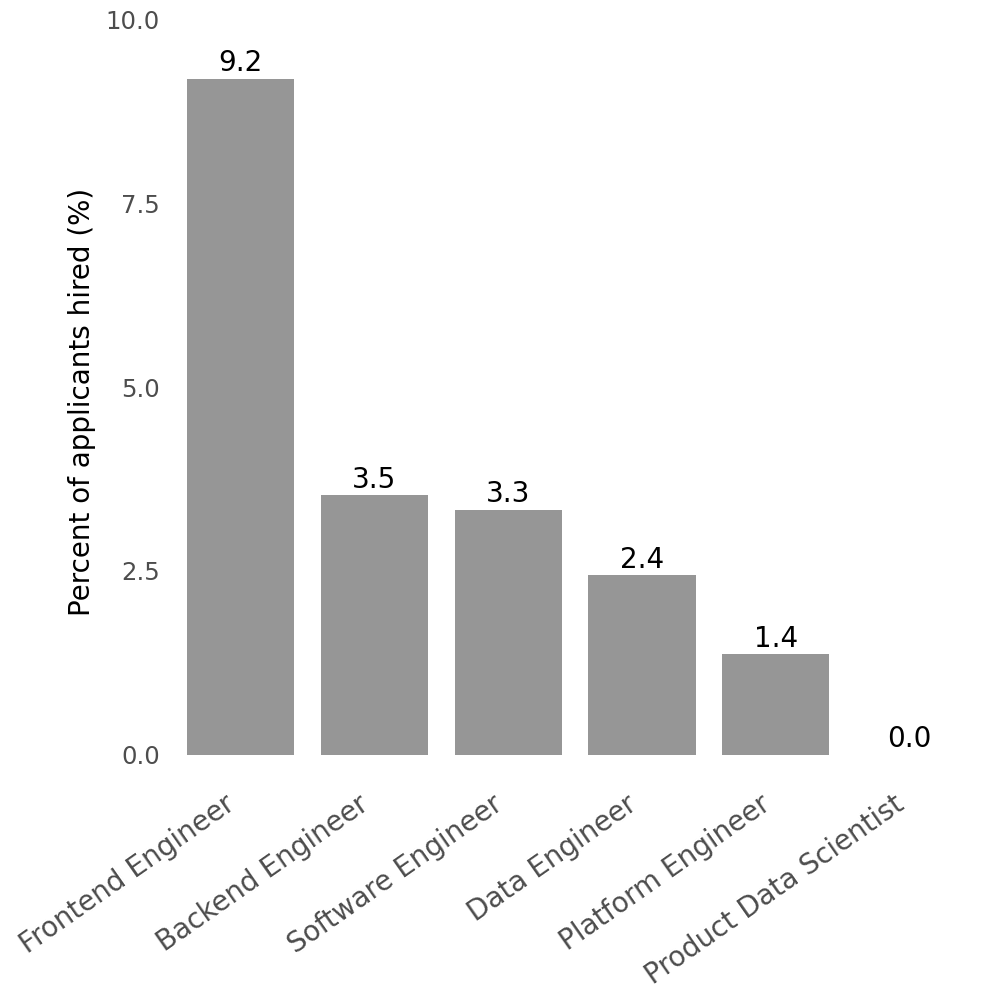

In [221]:
(
    ggplot(
        (
            hire_stats
            .sort_values('hire_rate', ascending=False)
            .assign(job_title=lambda x: pd.Categorical(x['job_title'], x['job_title'].unique(), ordered=True))
        ), 
        aes('job_title', 'hire_rate')
    )
    + geom_col(fill='#969696', width=0.8)
    + geom_text(
        aes(label='round(hire_rate, 1)'),
        color='black',  # Set the text color to white
        va='top',  # Vertical alignment: 'top', 'middle', 'bottom'
        nudge_y=0.4, # Nudge the text slightly down to be inside the bar
        size=10
    )        
    + theme_minimal()
    + labs(
        title="",
        x="",
        y="Percent of applicants hired (%)"
    )
    + theme(
        axis_text_x=element_text(angle=35, hjust=1, size=10),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        figure_size=(5, 5), # w, h
        axis_title_y=element_text(size=10),
    )
)

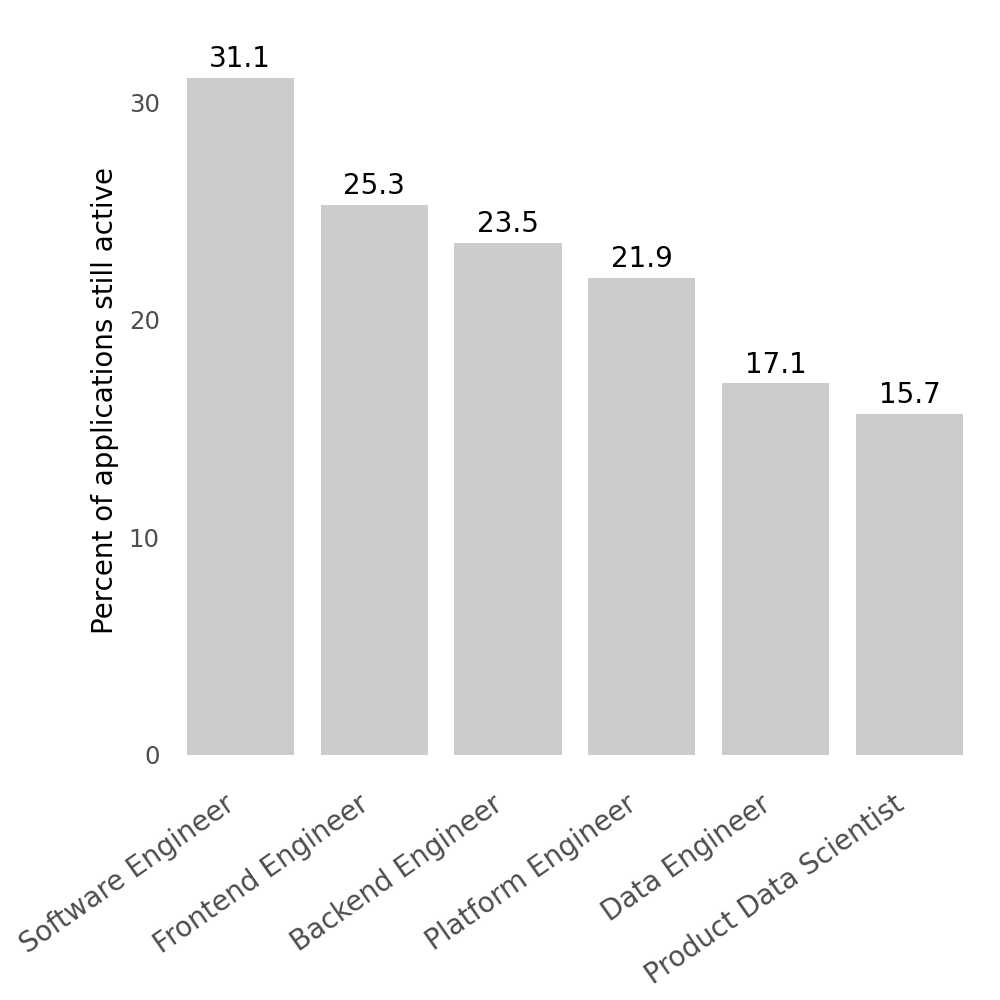

In [227]:
(
    ggplot(
        (
            hire_stats
            .sort_values('pct_active', ascending=False)
            .assign(job_title=lambda x: pd.Categorical(x['job_title'], x['job_title'].unique(), ordered=True))
        ), 
        aes('job_title', 'pct_active')
    )
    + geom_col(fill='#cccccc', width=0.8)
    + geom_text(
        aes(label='round(pct_active, 1)'),
        color='black',  # Set the text color to white
        va='top',  # Vertical alignment: 'top', 'middle', 'bottom'
        nudge_y=1.5, # Nudge the text slightly down to be inside the bar
        size=10
    )         
    + theme_minimal()
    + labs(
        title="",
        x="",
        y="Percent of applications still active"
    )
    + theme(
        axis_text_x=element_text(angle=35, hjust=1, size=10),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        figure_size=(5, 5), # w, h
        axis_title_y=element_text(size=10),
    )
)

In [56]:
%%sql percent_of_hires_by_source <<

WITH by_source AS (
    SELECT 
        source, 
        COUNT(*) AS hire_cnt,
        COUNT(*) / SUM(COUNT(*)) OVER () AS pct_of_total_hires
    FROM applications_data
    WHERE 
        1 = 1
        AND is_hired
    GROUP BY source
)

SELECT *
FROM by_source
ORDER BY pct_of_total_hires DESC

In [57]:
percent_of_hires_by_source

,source,hire_cnt,pct_of_total_hires
0,Referral,8,0.470588
1,Job Board,6,0.352941
2,Agency,3,0.176471


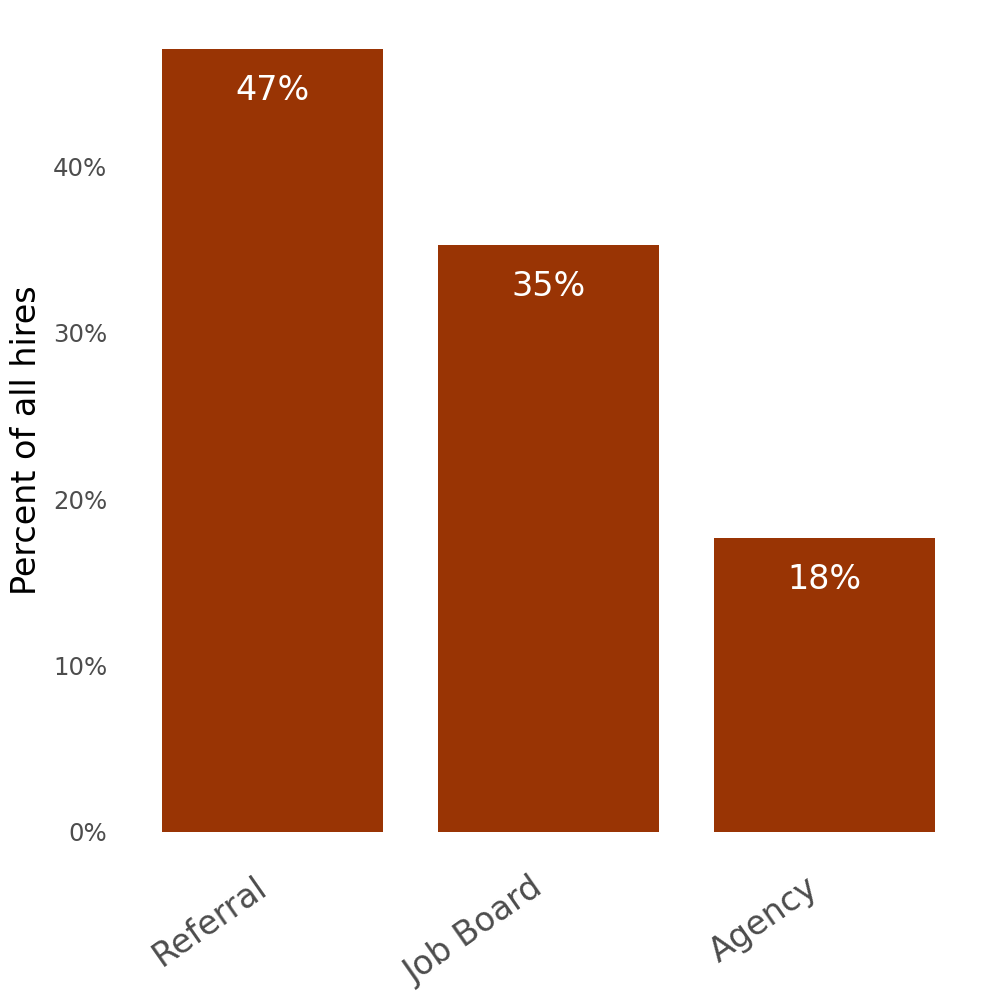

In [239]:
(
    ggplot(
        (
            percent_of_hires_by_source
            .sort_values('pct_of_total_hires', ascending=False)
            .assign(source=lambda x: pd.Categorical(x['source'], x['source'].unique(), ordered=True))
        ), 
        aes('source', 'pct_of_total_hires')
    )
    + geom_col(fill='#993404', width=0.8)
    + geom_text(
        aes(label='round(pct_of_total_hires, 2)'),
        color='white',  # Set the text color to white
        va='top',  # Vertical alignment: 'top', 'middle', 'bottom'
        nudge_y=-0.015, # Nudge the text slightly down to be inside the bar
        size=12,
        format_string='{:.0%}'
    )             
    + theme_minimal()
    + labs(
        title="",
        x="",
        y="Percent of all hires"
    )
    + theme(
        axis_text_x=element_text(angle=35, hjust=1, size=12),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        figure_size=(5, 5), # w, h
        axis_title_y=element_text(size=12),
    )
    + scale_y_continuous(labels=percent_format())
)

In [94]:
%%sql hire_rate_by_source <<

WITH by_source AS (
    SELECT 
        source, 
        COUNT(*) AS applicant_cnt,
        COUNTIF(is_hired) AS hire_cnt,
        COUNTIF(is_hired) / SUM(COUNT(*)) OVER (PARTITION BY source) AS hire_rate
    FROM applications_data
    WHERE 
        1 = 1
    GROUP BY source
)

SELECT *
FROM by_source
--ORDER BY pct_of_total_hires DESC

In [95]:
hire_rate_by_source

,source,applicant_cnt,hire_cnt,hire_rate
0,Job Board,237,6.0,0.025316
1,Agency,146,3.0,0.020548
2,Referral,117,8.0,0.068376


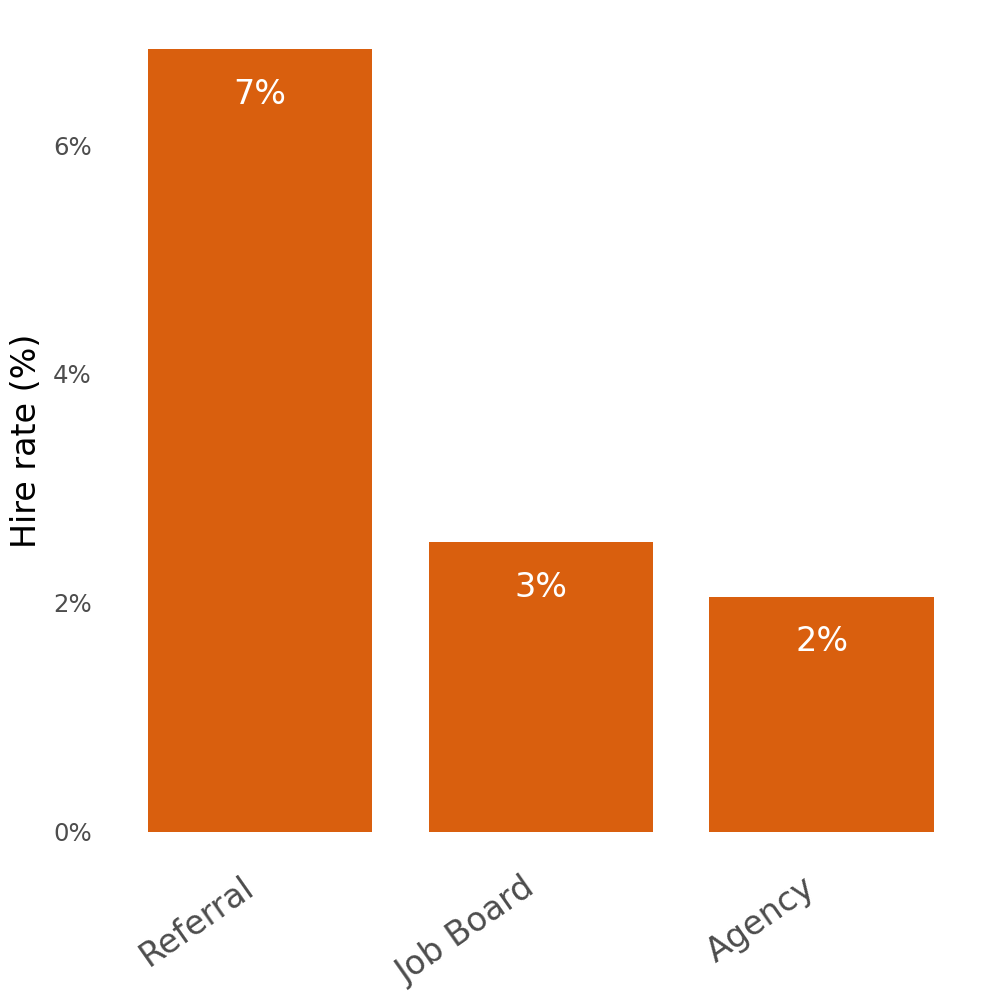

In [244]:
(
    ggplot(
        (
            hire_rate_by_source
            .sort_values('hire_rate', ascending=False)
            .assign(source=lambda x: pd.Categorical(x['source'], x['source'].unique(), ordered=True))
        ), 
        aes('source', 'hire_rate')
    )
    + geom_col(fill='#d95f0e', width=0.8)
    + geom_text(
        aes(label='round(hire_rate, 2)'),
        color='white',  # Set the text color to white
        va='top',  # Vertical alignment: 'top', 'middle', 'bottom'
        nudge_y=-0.0025, # Nudge the text slightly down to be inside the bar
        size=12,
        format_string='{:.0%}'
    )             
    + theme_minimal()
    + labs(
        title="",
        x="",
        y="Hire rate (%)"
    )
    + theme(
        axis_text_x=element_text(angle=35, hjust=1, size=12),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        figure_size=(5, 5), # w, h
        axis_title_y=element_text(size=12),
    )
    + scale_y_continuous(labels=percent_format())
)

In [66]:
%%sql applications_by_title_and_source <<

WITH by_source AS (
    SELECT 
        job_title,
        source, 
        COUNT(*) application_cnt,
        COUNT(*) / SUM(COUNT(*)) OVER (PARTITION BY job_title) AS pct_of_total_applications
    FROM applications_data
    WHERE 
        1 = 1
    GROUP BY source, job_title
    ORDER BY job_title, source
)

SELECT *
FROM by_source
WHERE 
    1 = 1
ORDER BY pct_of_total_applications DESC

In [67]:
applications_by_title_and_source

,job_title,source,application_cnt,pct_of_total_applications
0,Data Engineer,Job Board,43,0.524390
1,Product Data Scientist,Job Board,43,0.518072
2,Frontend Engineer,Job Board,41,0.471264
3,Backend Engineer,Job Board,40,0.470588
4,Platform Engineer,Job Board,34,0.465753
5,Software Engineer,Job Board,36,0.400000
6,Data Engineer,Agency,25,0.304878
7,Platform Engineer,Agency,22,0.301370
8,Software Engineer,Agency,27,0.300000
9,Software Engineer,Referral,27,0.300000


In [83]:
import numpy as np

(
    applications_by_title_and_source
    .pipe(lambda x: x[x.loc[:, 'source'] == 'Referral'])
    .assign(low_hire_rate=lambda x: np.where(np.isin(x.loc[:,'job_title'], ['Platform Engineer', 'Product Data Scientist', 'Data Engineer']), 'low hire rate', 'higher hire rate'))
    .groupby('low_hire_rate')['pct_of_total_applications']
    .mean()
    .reset_index(name='mean_hire_rate')
)

,low_hire_rate,mean_hire_rate
0,higher hire rate,0.262813
1,low hire rate,0.202809


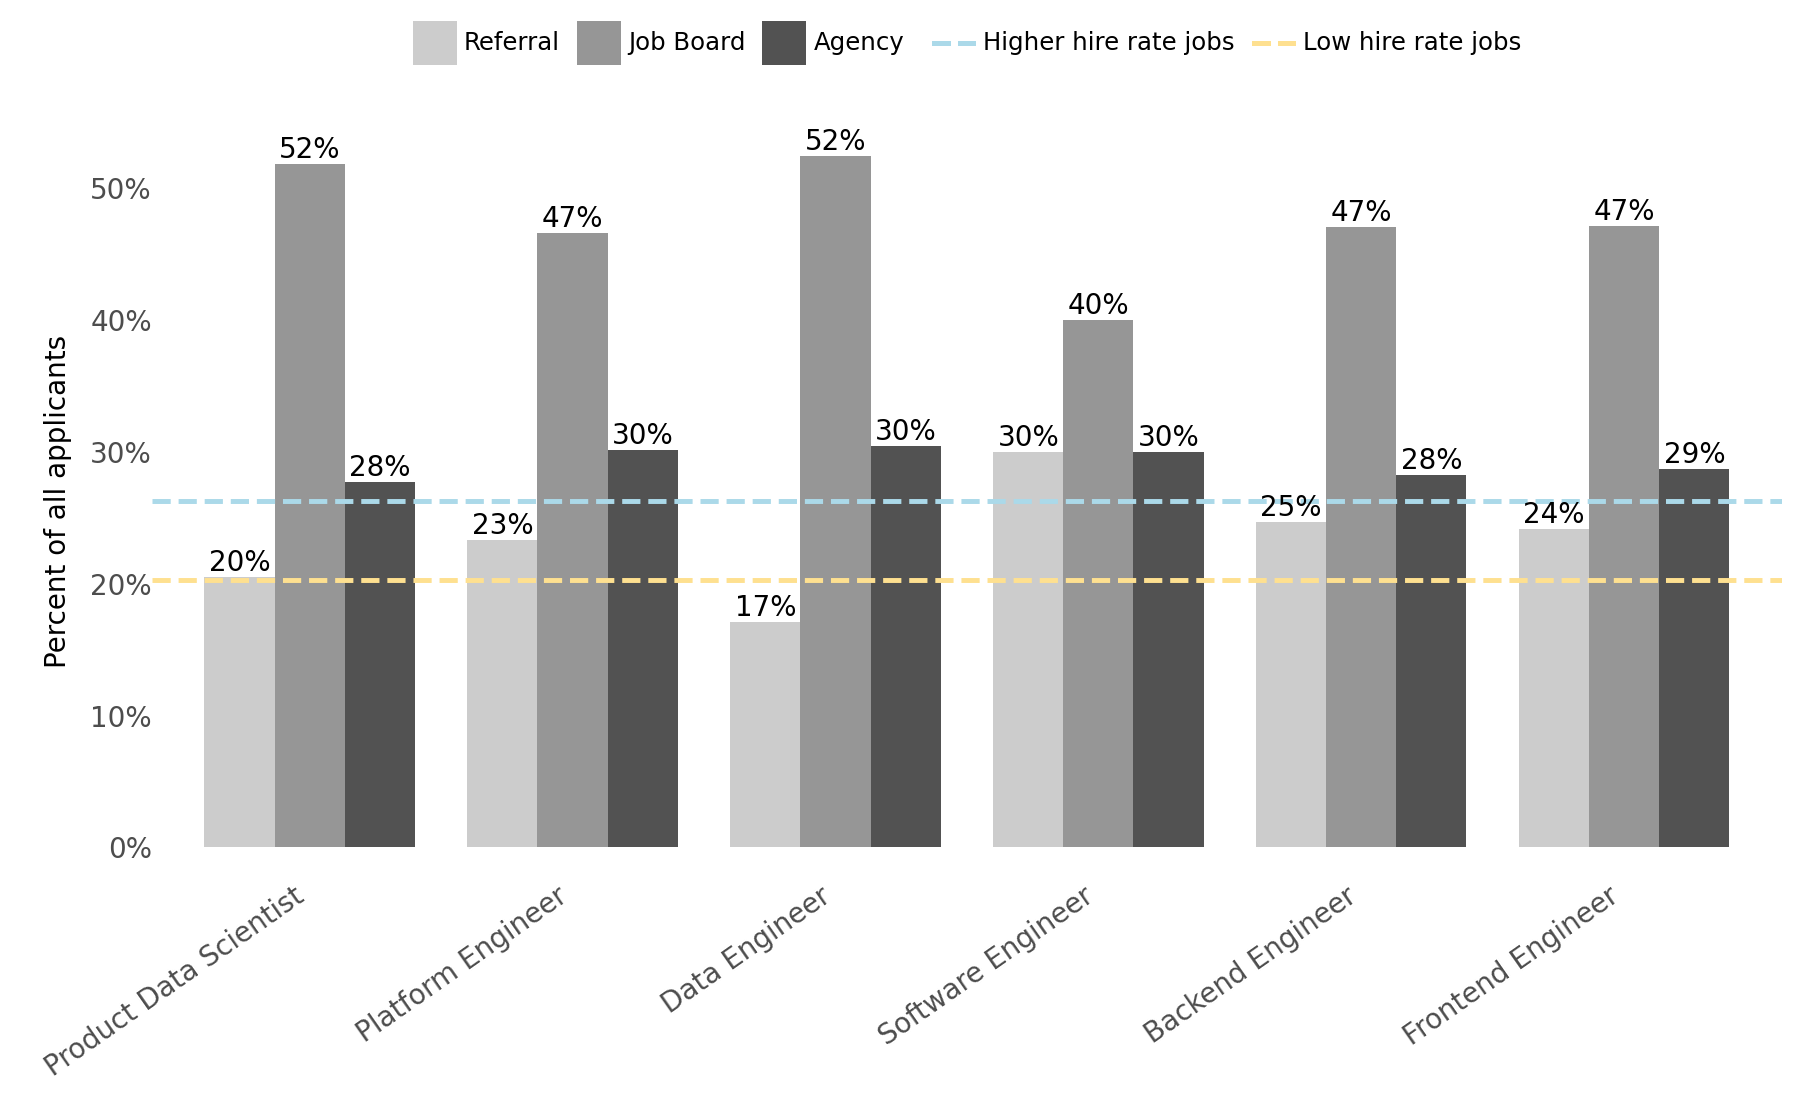

In [267]:
(
    ggplot(
        (
            applications_by_title_and_source
            .assign(source=lambda x: pd.Categorical(x['source'], ['Referral', 'Job Board', 'Agency'], ordered=True))
            .assign(job_title=lambda x: pd.Categorical(x['job_title'], ['Product Data Scientist', 'Platform Engineer', 'Data Engineer', 'Software Engineer', 'Backend Engineer', 'Frontend Engineer'], ordered=True))
        ),
        aes('job_title', 'pct_of_total_applications', group='source', fill='source')
    )
    + geom_col(stat="identity", position="dodge", width=0.8) # geom_col is generally better for pre-calculated y-values
    + geom_hline(
        (
            applications_by_title_and_source
            .pipe(lambda x: x[x.loc[:, 'source'] == 'Referral'])
            .assign(low_hire_rate=lambda x: np.where(np.isin(x.loc[:,'job_title'], ['Platform Engineer', 'Product Data Scientist', 'Data Engineer']), 'Low hire rate jobs', 'Higher hire rate jobs'))
            .groupby('low_hire_rate')['pct_of_total_applications']
            .mean()
            .reset_index(name='mean_hire_rate')
        ),
        aes(yintercept='mean_hire_rate', color='low_hire_rate'),
        linetype='dashed',
        size=1,
        # show_legend=False
    )    
    + geom_text(
        aes(label='pct_of_total_applications'),
        position=position_dodge(width=0.8),
        va='bottom',
        ha='center', 
        format_string='{:.0%}',
        size=10
    )
    + labs(
        title="",
        x="",
        y="Percent of all applicants"
    )    
    + theme_minimal()
    + theme(
        axis_text_x=element_text(angle=35, hjust=1, size=10),
        axis_text_y=element_text(size=10),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        figure_size=(9, 5.5), # w, h
        legend_title=element_blank(),
        axis_title_y=element_text(size=10),
        legend_position='top'
    )
    + scale_y_continuous(labels=percent_format())
    + scale_fill_manual(['#cccccc', '#969696', '#525252'])
    + scale_color_manual({'Low hire rate jobs': '#fee090', 'Higher hire rate jobs': '#abd9e9'})
)

# Hiring Velocity

In [179]:
(
    applications_data
    .pipe(lambda x: x[~x.loc[:,'still_active']])
    .pipe(lambda x: print(f'min: {x.hours_to_decision.min()}, max: {x.hours_to_decision.max()}'))
    
)

min: 0, max: 168


In [181]:
168/8

21.0

In [182]:
(
    applications_data
    .pipe(lambda x: x[~x.loc[:,'still_active']])
    .pipe(lambda x: x.hours_to_decision.mean() / 8)
)

np.float64(9.01421188630491)

/home/user/flask-dlt-dbt/.venv/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 9'. Pick better value with 'binwidth'.


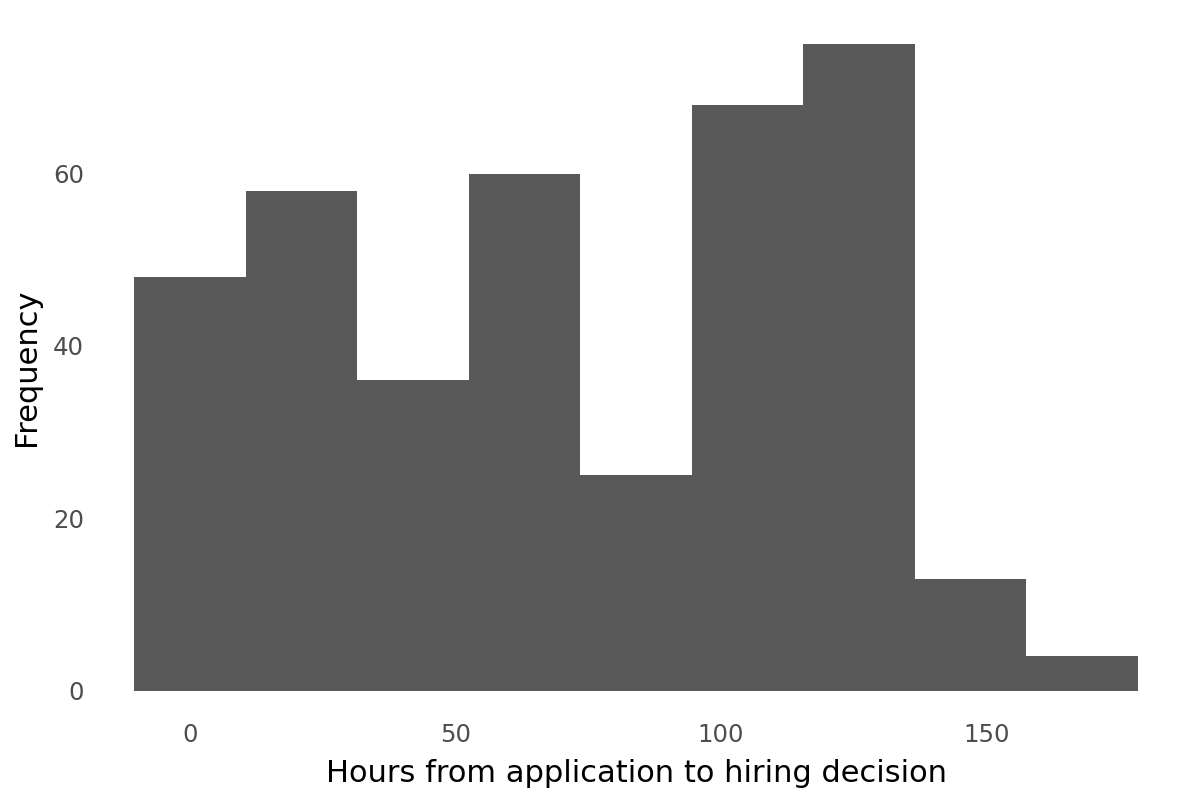

In [275]:
(
    ggplot(
        (
            applications_data
            .pipe(lambda x: x[~x.loc[:,'still_active']])
        ), 
        aes('hours_to_decision')
    )
    + geom_histogram()
    + theme_minimal()
    + labs(
        title="",
        x="Hours from application to hiring decision",
        y="Frequency"
    )    
    + theme_minimal()
    + theme(
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        figure_size=(6, 4), # w, h
    )
)   

/home/user/flask-dlt-dbt/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/user/flask-dlt-dbt/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/user/flask-dlt-dbt/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/user/flask-dlt-dbt/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/user/flask-dlt-dbt/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/user/flask-dlt-dbt/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: 

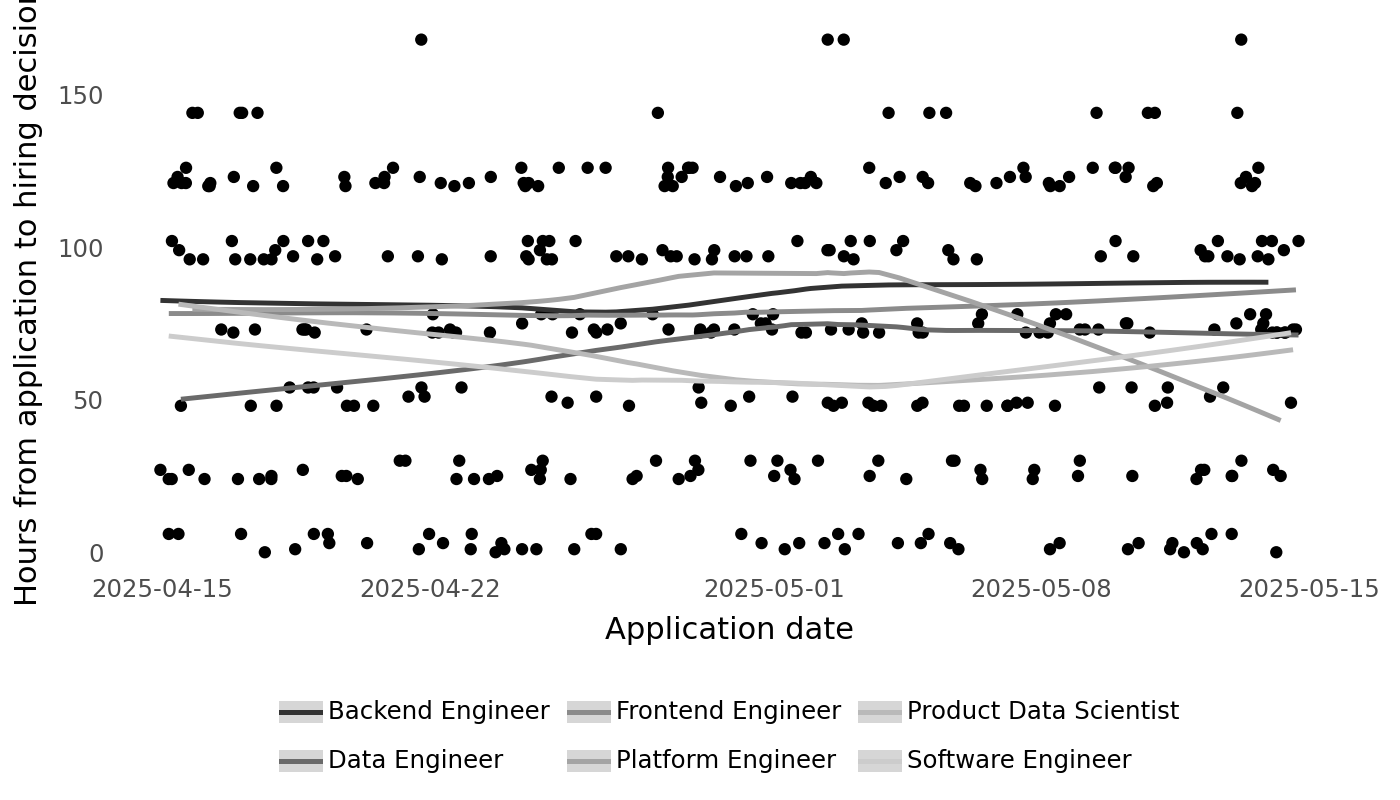

In [291]:
(
    ggplot(
        (
            applications_data
            .pipe(lambda x: x[~x.loc[:,'still_active']])
        ), 
        aes('application_date', 'hours_to_decision')
    )
    + geom_point(color='black')
    + geom_smooth(
        aes(color='job_title'), 
        # show_legend=False
    )
    + labs(
        title="",
        x="Application date",
        y="Hours from application to hiring decision"
    )    
    + theme_minimal()
    + theme(
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        figure_size=(7, 4), # w, h
        legend_title=element_blank(),
        legend_position='bottom'
    )
    + scale_color_grey()
)

In [104]:
%%sql

SELECT *
FROM applications_data
WHERE 
    1 = 1
    AND hours_to_decision < 8
    AND is_hired

,application_id,job_id,job_title,candidate_id,application_date,is_hired,was_offered,is_rejected,is_approved,approval_date,hours_to_approval,hours_to_decision,source
0,app_46,job_14,Backend Engineer,cand_46,2025-05-11 17:31:41.267706+00:00,True,True,False,True,2025-05-11 17:46:41.267706+00:00,0,0,Job Board
1,app_373,job_3,Backend Engineer,cand_373,2025-04-21 23:30:53.045041+00:00,True,True,False,True,2025-04-22 05:30:53.045041+00:00,6,6,Job Board
2,app_81,job_3,Frontend Engineer,cand_81,2025-04-15 04:04:17.567928+00:00,True,True,False,True,2025-04-15 10:04:17.567928+00:00,6,6,Referral
3,app_311,job_4,Backend Engineer,cand_311,2025-04-20 08:35:44.519263+00:00,True,True,False,True,2025-04-20 11:35:44.519263+00:00,3,3,Agency
4,app_341,job_19,Frontend Engineer,cand_341,2025-04-23 01:39:41.371024+00:00,True,True,False,True,2025-04-23 02:39:41.371024+00:00,1,1,Referral


In [12]:
%%sql 

SELECT 
    job_title,
    is_hired,
    COUNT(*) AS cnt
FROM applications_data
WHERE 
    1 = 1
    AND hours_to_decision < 8
GROUP BY 
    job_title,
    is_hired
ORDER BY is_hired, cnt DESC

,job_title,is_hired,cnt
0,Product Data Scientist,False,17
1,Software Engineer,False,15
2,Data Engineer,False,13
3,Platform Engineer,False,9
4,Frontend Engineer,False,7
5,Backend Engineer,False,5
6,Backend Engineer,True,3
7,Frontend Engineer,True,2


In [184]:
%%sql

SELECT 
    is_hired,
    AVG(hours_to_decision)/8 AS avg_hours_to_decision
FROM applications_data
WHERE 
    1 = 1
    AND NOT still_active
GROUP BY is_hired

,is_hired,avg_hours_to_decision
0,False,9.114527
1,True,6.830882


In [185]:
9.114527 - 6.830882

2.283645000000001

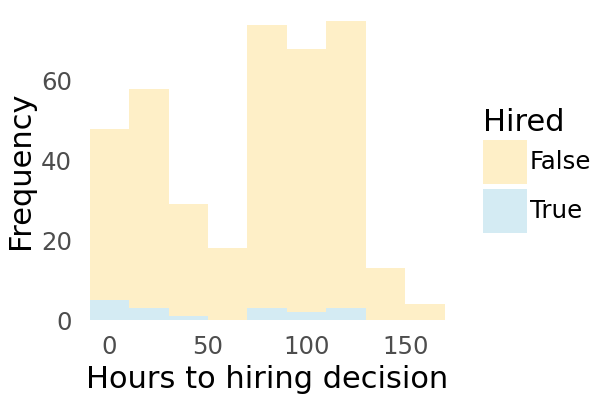

In [299]:
(
    ggplot(
        applications_data
        .pipe(lambda x: x[~x.loc[:,'still_active']]), 
        aes('hours_to_decision', fill='is_hired')
    )
    + geom_histogram(alpha=0.5, binwidth=20)
    + theme_minimal()
    + labs(
        title="",
        x="Hours to hiring decision",
        y="Frequency",
        fill='Hired'
    )    
    + theme(
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        figure_size=(3, 2), # w, h
    )    
    + scale_fill_manual({False: '#fee090', True: '#abd9e9'})
)



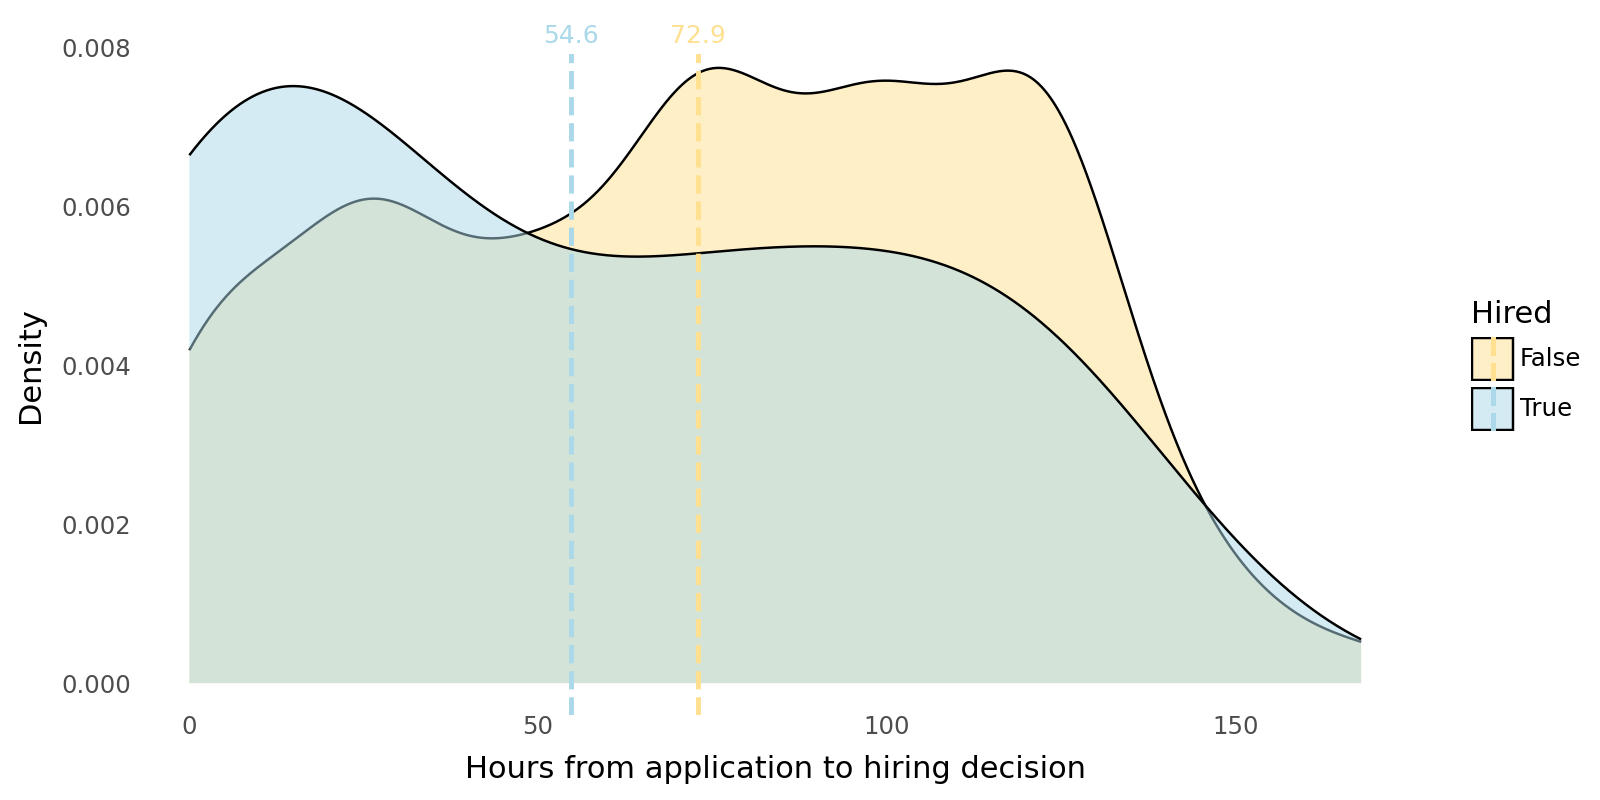

In [305]:
(
    ggplot(
        (
            applications_data
            .pipe(lambda x: x[~x.loc[:,'still_active']])
            # .pipe(lambda x: x[x.loc[:,'job_title'] != 'Platform Engineer'])
        ), 
        aes('hours_to_decision', fill='is_hired')
    )
    + geom_density(alpha=0.5)
    + geom_vline(
        (
            applications_data
            .pipe(lambda x: x[~x.loc[:,'still_active']])
            .groupby('is_hired')['hours_to_decision']
            .mean()
            .reset_index(name='avg_hours_to_decision')
        ),
        aes(xintercept='avg_hours_to_decision', color='is_hired'),
        linetype='dashed',
        size=1
    )
    + geom_label( # Changed to geom_label
        (
            applications_data
            .pipe(lambda x: x[~x.loc[:,'still_active']])
            .groupby('is_hired')['hours_to_decision']
            .mean()
            .reset_index(name='avg_hours_to_decision')
        ),
        aes(
            x='avg_hours_to_decision', 
            y=0.008, 
            label='avg_hours_to_decision', 
            color='is_hired'
        ),
        fill='white',
        ha='center',
        va='bottom',
        format_string='{:.1f}',
        size=9,
        label_size=0,
        show_legend=False
        # color='black'
    ) 
    + theme_minimal()
    + labs(
        title="",
        x="Hours from application to hiring decision",
        y="Density",
        fill='Hired',
        color='Hired'
    )    
    + theme(
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        figure_size=(8, 4), # w, h
    )    
    + scale_fill_manual({False: '#fee090', True: '#abd9e9'})
    + scale_color_manual({False: '#fee090', True: '#abd9e9'})
)

In [172]:
%%sql time_to_decision_by_source_and_outcome <<

SELECT 
    source,
    is_hired,
    AVG(hours_to_decision) AS avg_hours_to_decision,
    COUNT(*) AS count
FROM applications_data
WHERE
    1 = 1
    AND NOT still_active
GROUP BY source, is_hired

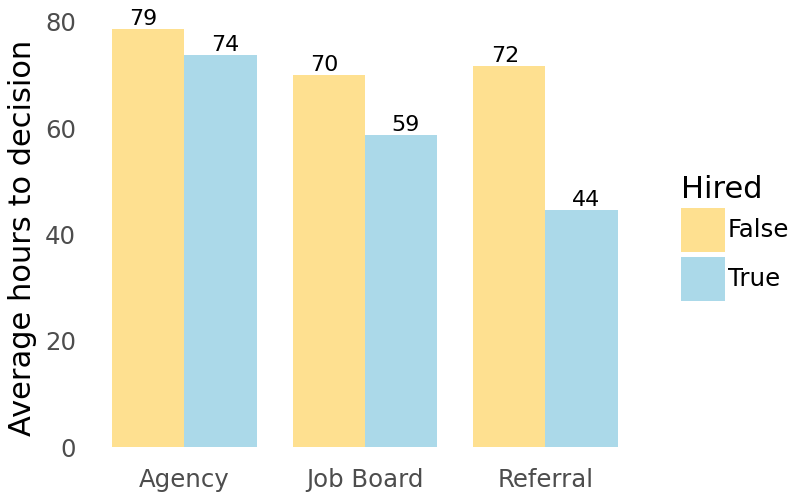

In [313]:
(
    ggplot(
        (
            time_to_decision_by_source_and_outcome
            # .pipe(lambda x: x[~x.loc[:,'is_hired']])
            .sort_values('avg_hours_to_decision')
            .assign(job_title=lambda x: pd.Categorical(x['source'], categories=x['source'].unique().tolist(), ordered=True))
        ),
        aes('source', 'avg_hours_to_decision', group='is_hired', fill='is_hired')
    )
    + geom_col(stat="identity", position="dodge", width=0.8) # geom_col is generally better for pre-calculated y-values
    + geom_text(
        aes(label='avg_hours_to_decision'),
        position=position_dodge(width=0.8),
        va='bottom',
        ha='center', 
        format_string='{:.0f}',
        size=8
    )
    + theme_minimal()
    + labs(
        title="",
        x="",
        y="Average hours to decision",
        fill='Hired'
    )    
    + theme(
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        figure_size=(4, 2.5), # w, h
    )    
    + scale_fill_manual({False: '#fee090', True: '#abd9e9'})
)

In [173]:
time_to_decision_by_source_and_outcome

,source,is_hired,avg_hours_to_decision,count
0,Referral,False,71.597222,72
1,Agency,False,78.637168,113
2,Job Board,True,58.666667,6
3,Job Board,False,69.935135,185
4,Referral,True,44.500000,8
5,Agency,True,73.666667,3


In [107]:
%%sql time_to_hire <<

SELECT 
    source,
    AVG(hours_to_decision) AS avg_hours_to_decision,
    COUNT(*) AS count
FROM applications_data
WHERE
    1 = 1
    AND is_hired
    AND NOT still_active
GROUP BY source

In [108]:
time_to_hire

,source,avg_hours_to_decision,count
0,Referral,44.500000,8
1,Job Board,58.666667,6
2,Agency,73.666667,3


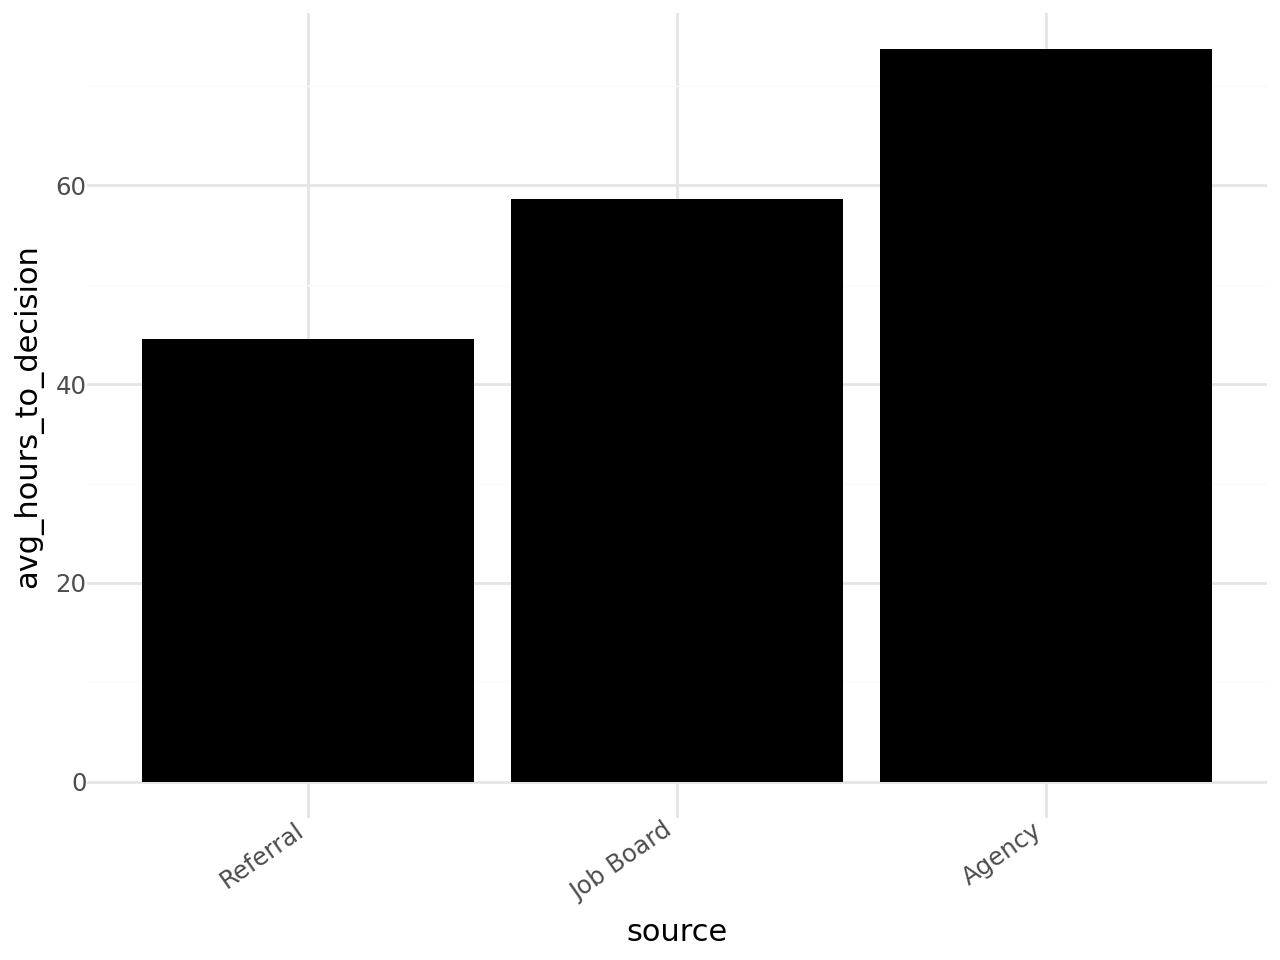

In [109]:
(
    ggplot(
        (
            time_to_hire
            .sort_values('avg_hours_to_decision', ascending=True)
            .assign(source=lambda x: pd.Categorical(x['source'], x['source'].unique(), ordered=True))
        ), 
        aes('source', 'avg_hours_to_decision')
    )
    + geom_col(fill='black')
    + theme_minimal()
    + theme(
        axis_text_x=element_text(angle=35, hjust=1)
    )
)

In [164]:
%%sql avg_hours_to_decision_by_job_title <<

SELECT 
    job_title,
    AVG(hours_to_decision) AS avg_hours_to_decision
FROM applications_data
WHERE 
    1=1
    AND NOT still_active
GROUP BY job_title
ORDER BY avg_hours_to_decision DESC

In [165]:
avg_hours_to_decision_by_job_title

,job_title,avg_hours_to_decision
0,Backend Engineer,83.246154
1,Frontend Engineer,79.046154
2,Platform Engineer,78.403509
3,Data Engineer,67.176471
4,Product Data Scientist,64.257143
5,Software Engineer,61.677419


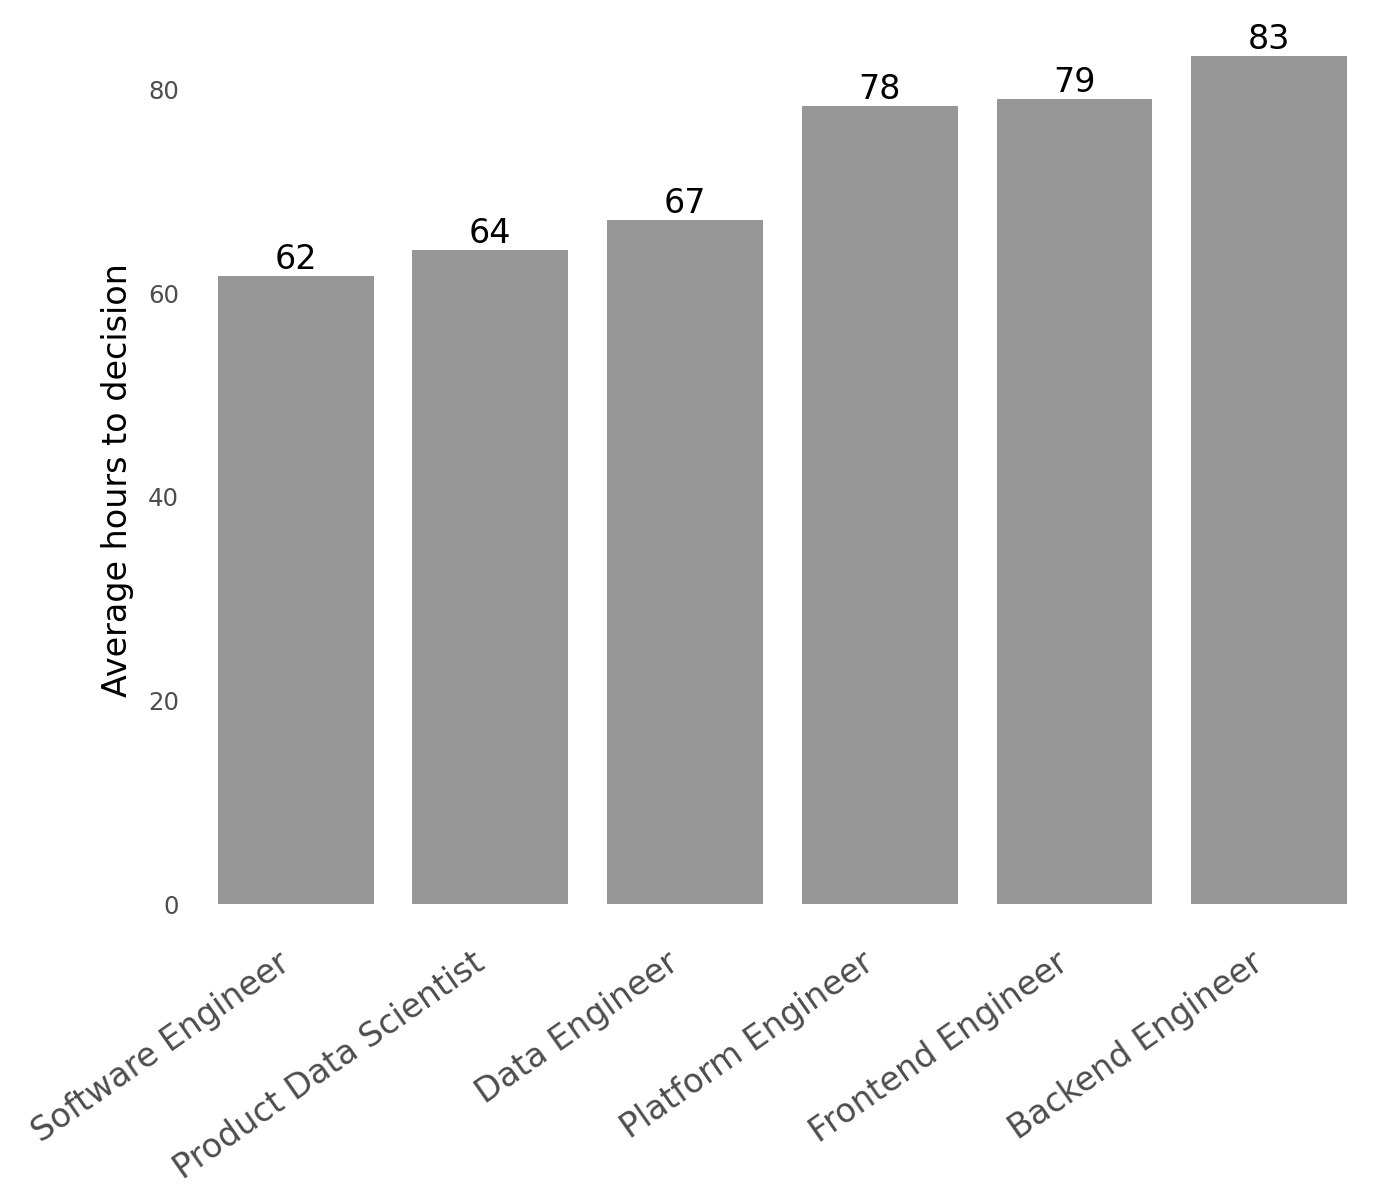

In [331]:
(
    ggplot(
        (
            avg_hours_to_decision_by_job_title
            # .pipe(lambda x: x[~x.loc[:,'is_hired']])
            .sort_values('avg_hours_to_decision')
            .assign(job_title=lambda x: pd.Categorical(x['job_title'], categories=x['job_title'].unique().tolist(), ordered=True))
        ),
        aes('job_title', 'avg_hours_to_decision')
    )
    + geom_col(fill='#969696', width=0.8)
    + geom_text(
        aes(label='avg_hours_to_decision'),
        # position=position_dodge(width=0.9),
        va='bottom',
        ha='center', 
        format_string='{:.0f}',
        size=12
    )
    + theme_minimal()
    + labs(
        title="",
        x="",
        y="Average hours to decision"
    )
    + theme(
        axis_text_x=element_text(angle=35, hjust=1, size=12),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        figure_size=(7, 6), # w, h
        axis_title_y=element_text(size=12),
    )    
)

In [157]:
%%sql avg_hours_to_decision_by_outcome_and_job_title <<

SELECT 
    is_hired,
    job_title,
    AVG(hours_to_decision) AS avg_hours_to_decision
FROM applications_data
WHERE NOT still_active
GROUP BY is_hired, job_title
ORDER BY job_title, is_hired

In [158]:
avg_hours_to_decision_by_outcome_and_job_title

,is_hired,job_title,avg_hours_to_decision
0,False,Backend Engineer,87.129032
1,True,Backend Engineer,3.000000
2,False,Data Engineer,66.924242
3,True,Data Engineer,75.500000
4,False,Frontend Engineer,81.052632
5,True,Frontend Engineer,64.750000
6,False,Platform Engineer,79.321429
7,True,Platform Engineer,27.000000
8,False,Product Data Scientist,64.257143
9,False,Software Engineer,61.016949


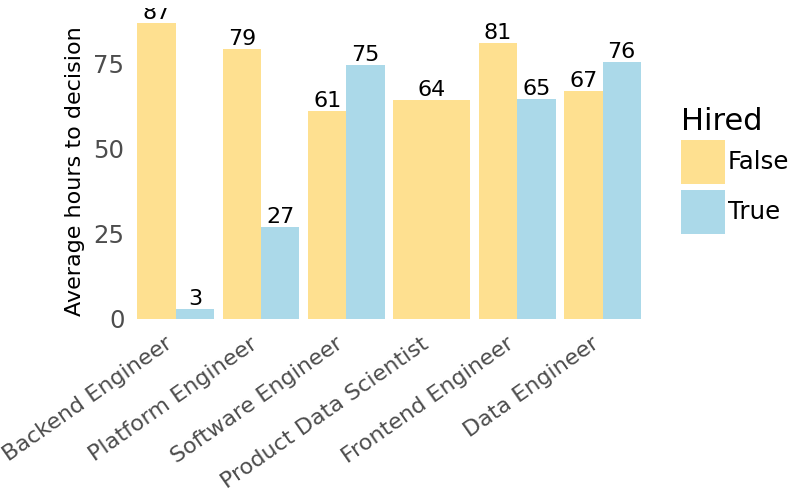

In [329]:
(
    ggplot(
        (
            avg_hours_to_decision_by_outcome_and_job_title
            # .pipe(lambda x: x[~x.loc[:,'is_hired']])
            .sort_values('avg_hours_to_decision')
            .assign(job_title=lambda x: pd.Categorical(x['job_title'], categories=x['job_title'].unique().tolist(), ordered=True))
        ),
        aes('job_title', 'avg_hours_to_decision', group='is_hired', fill='is_hired')
    )
    + geom_col(stat="identity", position="dodge") # geom_col is generally better for pre-calculated y-values
    + geom_text(
        aes(label='avg_hours_to_decision'),
        position=position_dodge(width=0.9),
        va='bottom',
        ha='center', 
        format_string='{:.0f}',
        size=8
    )
    + theme_minimal()
    + labs(
        title="",
        x="",
        y="Average hours to decision",
        fill='Hired'
    )    
    + theme(
        axis_text_x=element_text(angle=35, hjust=1, size=8),
        axis_title_y=element_text(size=8),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        figure_size=(4, 2.5), # w, h
    )    
    + scale_fill_manual({False: '#fee090', True: '#abd9e9'})
)

In [169]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf


ttest_result = statsmodels.stats.weightstats.ttest_ind(
    applications_data.pipe(lambda x: x[x.loc[:,'is_hired']].hours_to_decision.values),
    applications_data.pipe(lambda x: x[~x.loc[:,'is_hired'] & ~x.loc[:,'still_active']].hours_to_decision.values),
    alternative='two-sided', 
    usevar='unequal', 
    weights=(None, None), 
    value=0
)

print(ttest_result)

mod = smf.ols(
    formula='hours_to_decision ~ source', 
    data=(
        applications_data
        .pipe(lambda x: x[x.loc[:,'is_hired']])
    )
)

res = mod.fit()

# lm
print(res.summary())

# anova
print(sm.stats.anova_lm(res, typ=2))

(np.float64(-1.580492124612293), np.float64(0.1321507953238058), np.float64(17.254433923451263))
                            OLS Regression Results                            
Dep. Variable:      hours_to_decision   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                 -0.077
Method:                 Least Squares   F-statistic:                    0.4256
Date:                Mon, 23 Jun 2025   Prob (F-statistic):              0.662
Time:                        15:58:54   Log-Likelihood:                -88.473
No. Observations:                  17   AIC:                             182.9
Df Residuals:                      14   BIC:                             185.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

/home/user/flask-dlt-dbt/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=17 observations were given.


In [147]:
%%sql

SELECT 
    job_title,
    AVG(hours_to_decision) AS avg_hours_to_decision,
    COUNT(*) AS number_of_hires
FROM applications_data
WHERE 
    1 = 1
    AND NOT still_active
    --AND is_hired
GROUP BY job_title
ORDER BY avg_hours_to_decision DESC

,job_title,avg_hours_to_decision,number_of_hires
0,Backend Engineer,83.246154,65
1,Frontend Engineer,79.046154,65
2,Platform Engineer,78.403509,57
3,Data Engineer,67.176471,68
4,Product Data Scientist,64.257143,70
5,Software Engineer,61.677419,62


In [150]:
mod = smf.ols(
    formula='hours_to_decision ~ job_title', 
    data=(
        applications_data
        .pipe(lambda x: x[~x.loc[:,'still_active']])
    )
)

res = mod.fit()

# lm
print(res.summary())

# anova
print(sm.stats.anova_lm(res, typ=2))

                            OLS Regression Results                            
Dep. Variable:      hours_to_decision   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     2.888
Date:                Mon, 23 Jun 2025   Prob (F-statistic):             0.0142
Time:                        15:51:01   Log-Likelihood:                -1997.8
No. Observations:                 387   AIC:                             4008.
Df Residuals:                     381   BIC:                             4031.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [24]:
hire_info_counts

,source,is_hired,count,pct
0,Agency,False,143,97.945205
1,Job Board,False,231,97.468354
2,Referral,False,109,93.162393
3,Agency,True,3,2.054795
4,Job Board,True,6,2.531646
5,Referral,True,8,6.837607


In [25]:
from statsmodels.stats.contingency_tables import Table

contingency_table = hire_info_counts.pivot_table(index='source', columns='is_hired', values='count')

table = Table(contingency_table)
result = table.test_nominal_association()

print("Chi-square test results:")
print("Chi-square statistic:", result.statistic)
print("p-value:", result.pvalue)

Chi-square test results:
Chi-square statistic: 5.558126805571808
p-value: 0.06209663968956591


In [186]:
mod = smf.ols(
    formula='hours_to_decision ~ source', 
    data=(
        applications_data
        .pipe(lambda x: x[~x.loc[:,'still_active']])
    )
)

res = mod.fit()

# lm
print(res.summary())

# anova
print(sm.stats.anova_lm(res, typ=2))

                            OLS Regression Results                            
Dep. Variable:      hours_to_decision   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.840
Date:                Mon, 23 Jun 2025   Prob (F-statistic):              0.160
Time:                        16:58:18   Log-Likelihood:                -2003.2
No. Observations:                 387   AIC:                             4012.
Df Residuals:                     384   BIC:                             4024.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              78.5086    